## Lab - EDA Bivariate Analysis: Diving into Amazon UK Product Insights Part II

**Objective**: Delve into the dynamics of product pricing on Amazon UK to uncover insights that can inform business strategies and decision-making.

**Dataset**: This lab utilizes the [Amazon UK product dataset](https://www.kaggle.com/datasets/asaniczka/uk-optimal-product-price-prediction/)
which provides information on product categories, brands, prices, ratings, and more from from Amazon UK. You'll need to download it to start working with it.

---

**Submission**: Submit a Jupyter Notebook which contains code and a business-centric report summarizing your findings. 

**Bonus**: 

- Do the same analysis without taking out the outliers. What are your insights?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
url = "/Users/danielebelmiro/Downloads/amz_uk_price_prediction_dataset.csv"

df = pd.read_csv(url)

In [3]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    
    - Are there categories where being a best-seller is more prevalent? 
    	
    	*Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.*


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

In [5]:
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])
crosstab_result = crosstab_result.sort_values(by=True, ascending=False)
crosstab_result

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
...,...,...
Downhill Ski Boots,1284,0
Digital Frames,774,0
Motorbike Chassis,107,0


In [7]:
# Calculate total items per category
total_per_category = crosstab_result.sum(axis=1)

# Calculate best-seller count per category
best_sellers_per_category = crosstab_result[True]

# Compute the proportion of best-sellers
proportion_best_sellers = best_sellers_per_category / total_per_category

# Convert to DataFrame for better visualization
proportion_df = proportion_best_sellers.to_frame(name="best_seller_proportion")

# Sort in descending order
proportion_df = proportion_df.sort_values(by="best_seller_proportion", ascending=False)

proportion_df

,best_seller_proportion
category,
Grocery,0.058135
Smart Home Security & Lighting,0.057692
Health & Personal Care,0.057686
Mobile Phone Accessories,0.042471
Power & Hand Tools,0.035339
...,...
Vases,0.000000
Blank Media Cases & Wallets,0.000000
Bedding Collections,0.000000


In [13]:
from scipy.stats import chi2_contingency

chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value

(36540.202700613874, 0.0)

In [9]:
from scipy.stats.contingency import association

# Computing the association between variables in 'crosstab_result' using the "cramer" method
association(crosstab_result, method="cramer")

0.12228294397605641

<Axes: xlabel='category'>

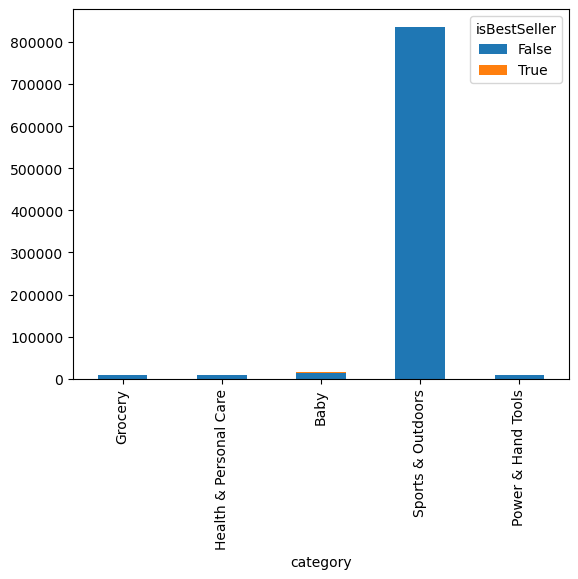

In [15]:
# Plotting a stacked bar chart for the 'crosstab_result' data
crosstab_result_top_5 = crosstab_result.head()
crosstab_result_top_5.plot(kind="bar", stacked=True)

### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

In [28]:
def tukeys_test_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    return outliers, lower_bound, upper_bound  # Retorna também os limites

# Aplicar a função
data_series = df['price']
outliers, lower_bound, upper_bound = tukeys_test_outliers(data_series)  # Captura os limites

# Agora podemos usar lower_bound e upper_bound para filtrar o DataFrame corretamente
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
df_filtered

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


<Axes: xlabel='category', ylabel='price'>

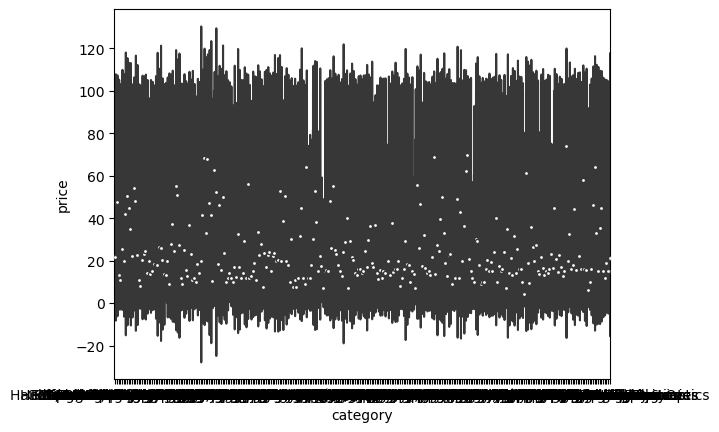

In [30]:
# Plotting a violin plot to visualize the distribution of 'price' for each category, using the "coolwarm" color palette
sns.violinplot(data=df_filtered, x='category', y='price', palette="coolwarm")

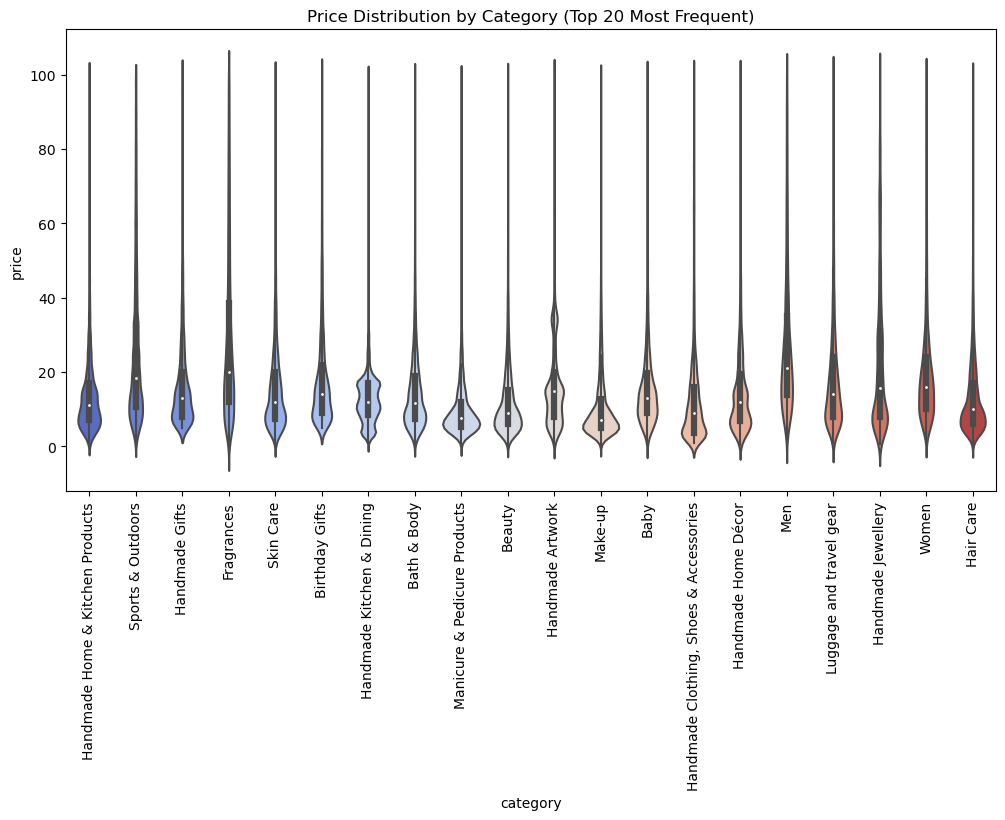

In [31]:
# Count the frequency of each category
top_categories = df_filtered['category'].value_counts().nlargest(20).index

# Filter the DataFrame to only include these categories
df_top_categories = df_filtered[df_filtered['category'].isin(top_categories)]

# Create the violin plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_top_categories, x='category', y='price', palette="coolwarm")
plt.xticks(rotation=90)  # Rotate category names for better visualization
plt.title("Price Distribution by Category (Top 20 Most Frequent)")
plt.show()

In [32]:
# Calculate the median price for each category
median_prices = df_filtered.groupby('category')['price'].median()

# Identify the category with the highest median price
highest_median_category = median_prices.idxmax()
highest_median_price = median_prices.max()

print(f"The category with the highest median price is '{highest_median_category}', with a median price of {highest_median_price:.2f}.")

The category with the highest median price is 'Desktop PCs', with a median price of 74.00.


Bar Charts:

Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
Which product category commands the highest average price? Don't filter here by top categories.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Sports & Outdoors'),
  Text(1, 0, 'Handmade Gifts'),
  Text(2, 0, 'Skin Care'),
  Text(3, 0, 'Birthday Gifts'),
  Text(4, 0, 'Bath & Body'),
  Text(5, 0, 'Manicure & Pedicure Products'),
  Text(6, 0, 'Beauty'),
  Text(7, 0, 'Make-up'),
  Text(8, 0, 'Handmade Clothing, Shoes & Accessories'),
  Text(9, 0, 'Hair Care')])

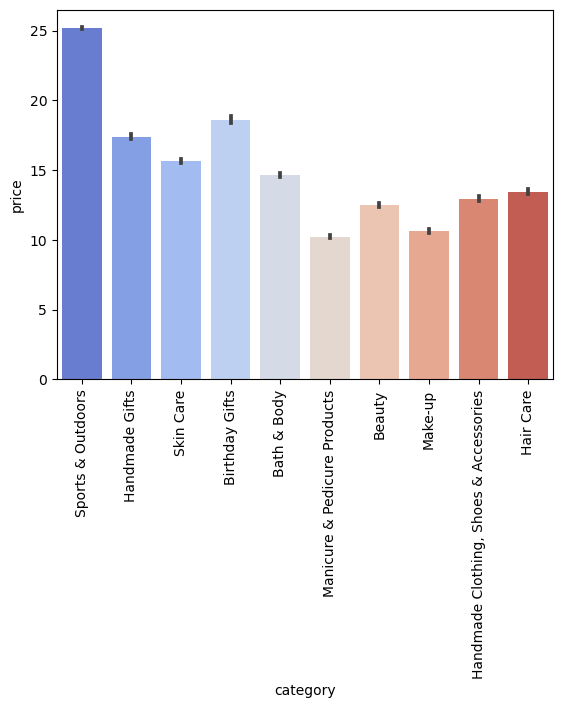

In [34]:
# Count the frequency of each category
top_categories = df_filtered['category'].value_counts().nlargest(10).index

# Filter the DataFrame to only include these categories
df_top_categories = df_filtered[df_filtered['category'].isin(top_categories)]


# Plotting a bar plot to visualize the average 'price' for each category, using the "coolwarm" color palette

sns.barplot(data=df_top_categories, x='category', y='price', palette="coolwarm")
plt.xticks(rotation=90)  # Rotate category names for better visualization

In [35]:
# Calculate the median price for each category
average_prices = df_filtered.groupby('category')['price'].mean()

# Identify the category with the highest median price
highest_average_category = average_prices.idxmax()
highest_average_price = average_prices.max()

print(f"The category with the highest average price is '{highest_average_category}', with an average price of {highest_average_price:.2f}.")

The category with the highest average price is 'Motherboards', with an average price of 68.77.


Box Plots:

Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Sports & Outdoors'),
  Text(1, 0, 'Handmade Gifts'),
  Text(2, 0, 'Skin Care'),
  Text(3, 0, 'Birthday Gifts'),
  Text(4, 0, 'Bath & Body'),
  Text(5, 0, 'Manicure & Pedicure Products'),
  Text(6, 0, 'Beauty'),
  Text(7, 0, 'Make-up'),
  Text(8, 0, 'Handmade Clothing, Shoes & Accessories'),
  Text(9, 0, 'Hair Care')])

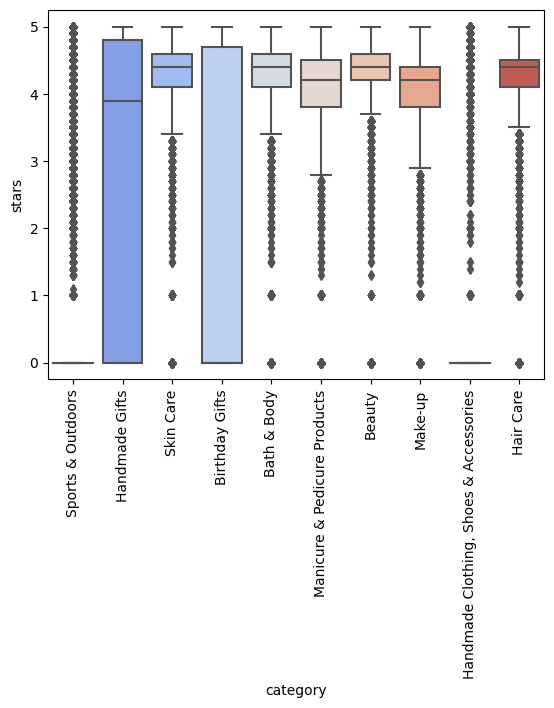

In [38]:
sns.boxplot(data=df_top_categories, x='category', y='stars', palette="coolwarm")
plt.xticks(rotation=90)  # Rotate category names for better visualization

In [39]:
median_stars = df_filtered.groupby('category')['stars'].median()

highest_median_category = median_stars.idxmax()
highest_median_stars = median_stars.max()

print(f"The category with the highest median rating is '{highest_median_category}', with a median rating of {highest_median_stars:.2f}.")

The category with the highest median rating is 'Computer Memory', with a median rating of 4.70.


### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.

1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?
	
2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

In [16]:
# Calculating the Pearson correlation coefficient
correlation = df['price'].corr(df['stars'])
correlation

-0.12490673262148386

In [17]:
# Calculating the Spearman rank correlation
correlation = df['price'].corr(df['stars'], method='spearman')
correlation

-0.13316425462433876

<Axes: xlabel='price', ylabel='stars'>

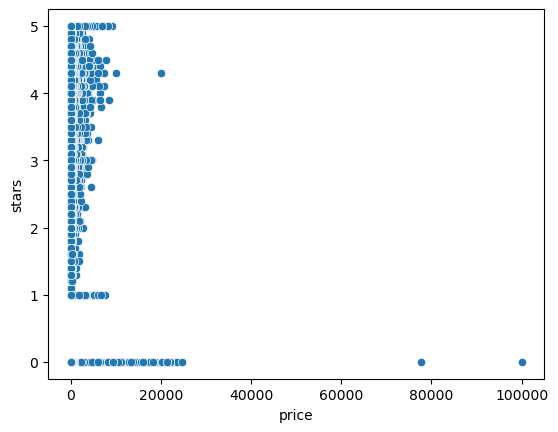

In [18]:
sns.scatterplot(data=df, x='price', y='stars')

<Axes: xlabel='price', ylabel='stars'>

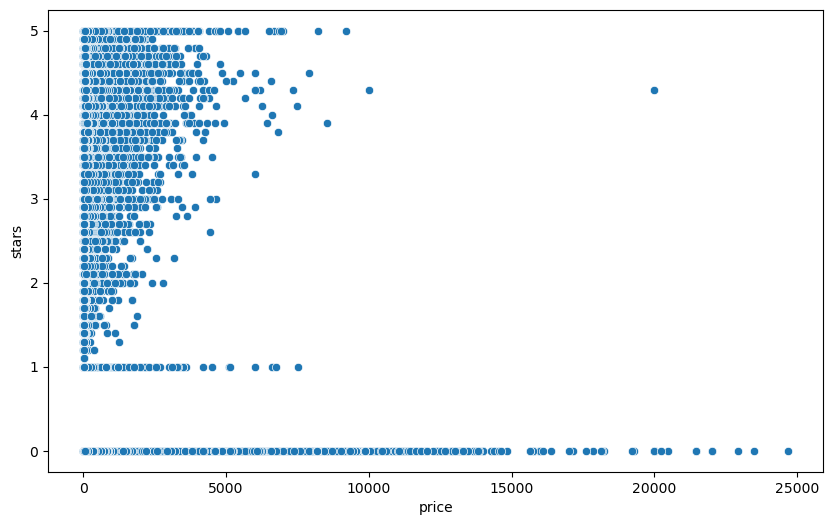

In [19]:
df_filtered = df[df['price'] <= 40000]

# scatter plot without outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='price', y='stars')

<Axes: xlabel='price', ylabel='stars'>

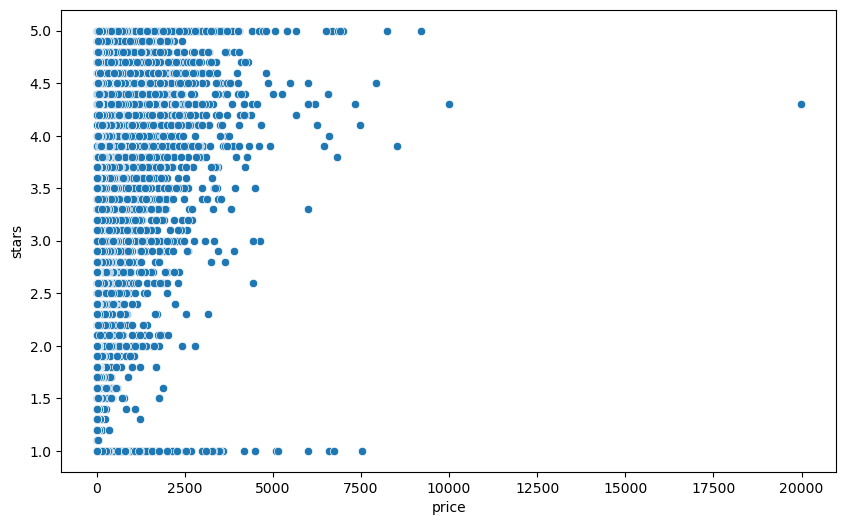

In [21]:
df_filtered = df[(df['price'] > 1) & (df['price'] <= 40000) & (df['stars'] > 0)]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='price', y='stars')

<Axes: xlabel='price', ylabel='stars'>

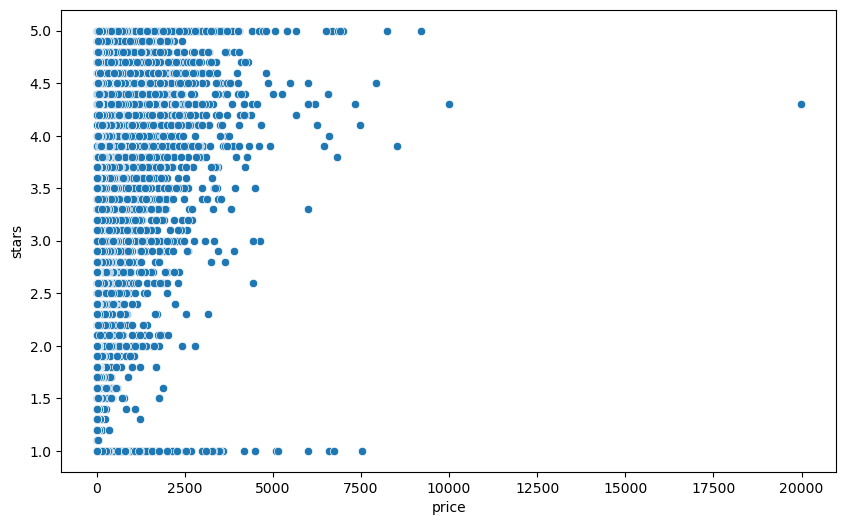

In [22]:
# Remover NaNs e garantir que 'price' seja numérico
df['price'] = pd.to_numeric(df['price'], errors='coerce')  # Converte e substitui erros por NaN
df['stars'] = pd.to_numeric(df['stars'], errors='coerce')  # Converte 'stars' para numérico também

# Filtrar produtos com preço maior que 1 e menor ou igual a 40.000 e estrelas > 0
df_filtered = df[(df['price'] > 1) & (df['price'] <= 40000) & (df['stars'] > 0)]

# Criar scatter plot sem outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='price', y='stars')

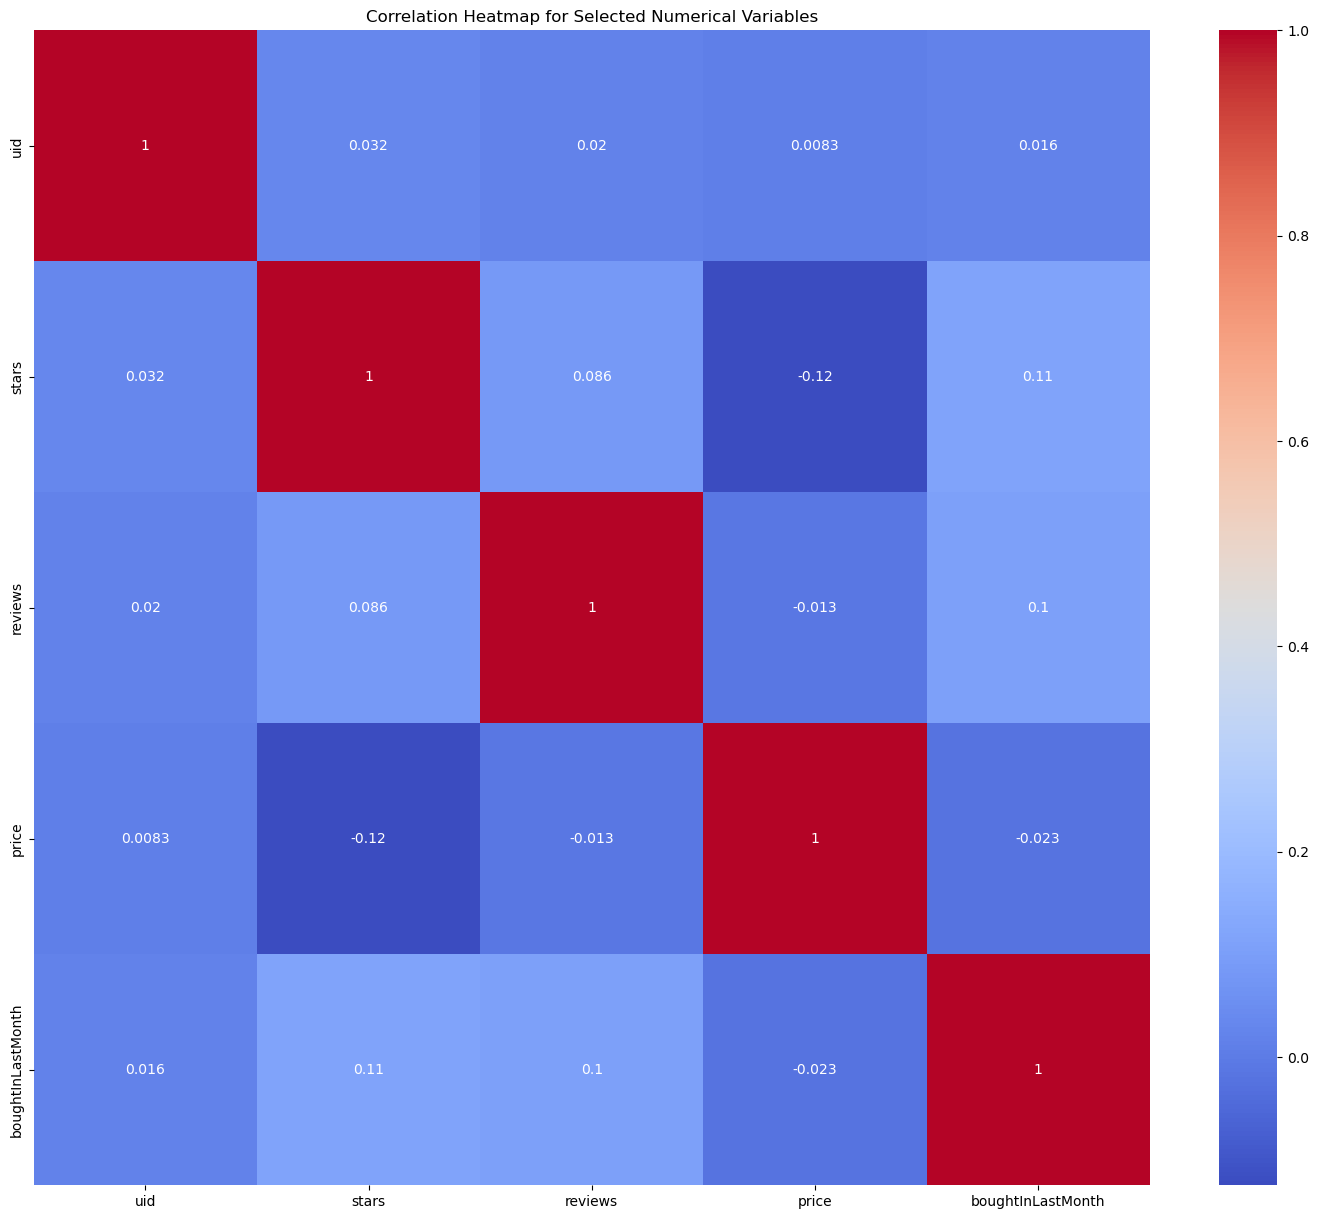

In [24]:
df_numerical = df.select_dtypes("number")

correlation_matrix = df_numerical.corr()

# Setting up the matplotlib figure with an appropriate size
plt.figure(figsize=(18, 15))

# Drawing the heatmap for the numerical columns
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

plt.title("Correlation Heatmap for Selected Numerical Variables")
plt.show()

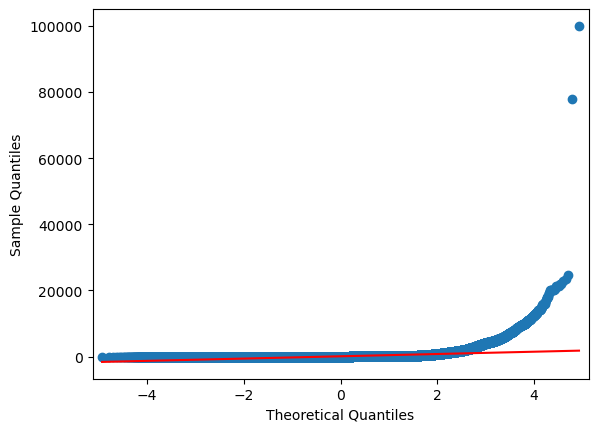

In [25]:
import statsmodels.api as sm

# Generating a Q-Q plot for 'price' to check if its distribution follows a normal distribution
sm.qqplot(df['price'], line='s');